In [ ]:
!pip install -q transformers datasets evaluate accelerate

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,time
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


import evaluate, numpy as np

os.makedirs("results", exist_ok=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'label'],
    num_rows: 108000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 12000
})


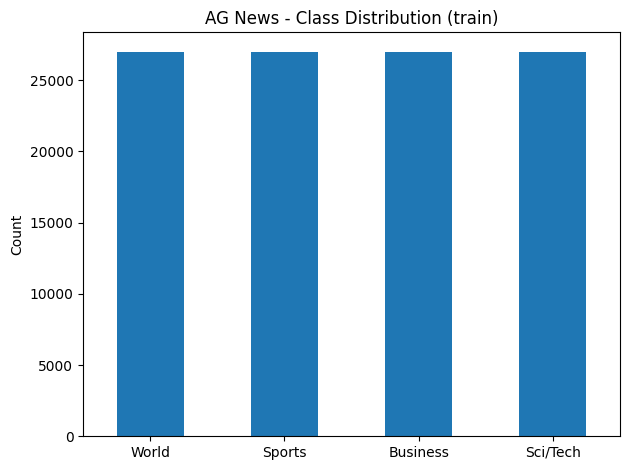

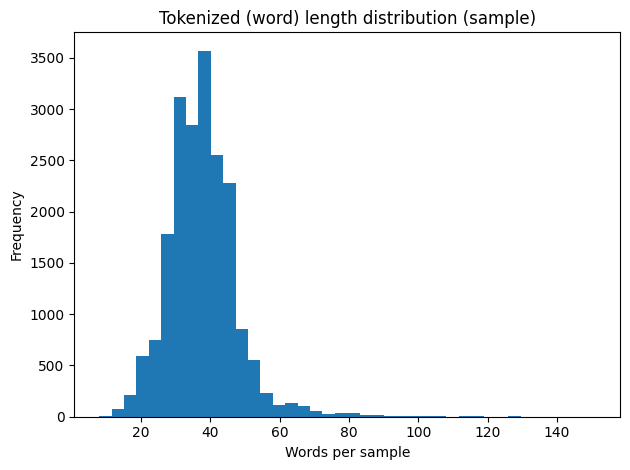

In [ ]:
# Data

ds = load_dataset("ag_news")
split = ds["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = ds["test"]
len(train_ds), len(val_ds), len(test_ds)
print(train_ds)
print(val_ds)

labels = ["World","Sports","Business","Sci/Tech"]
counts = pd.Series(train_ds["label"]).value_counts().sort_index()
plt.figure()
counts.plot(kind="bar")
plt.xticks(range(4), labels, rotation=0)
plt.title("AG News - Class Distribution (train)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("results/eda_class_dist.png", dpi=300)
plt.show()

#word-level
lengths = [len(x.split()) for x in train_ds["text"][:20000]]
plt.figure()
plt.hist(lengths, bins=40)
plt.title("Tokenized (word) length distribution (sample)")
plt.xlabel("Words per sample")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("results/eda_len_hist.png", dpi=300)
plt.show()

{'p50': 51.0, 'p95': 82.0, 'trunc@128': 0.00805, 'trunc@256': 0.00065}


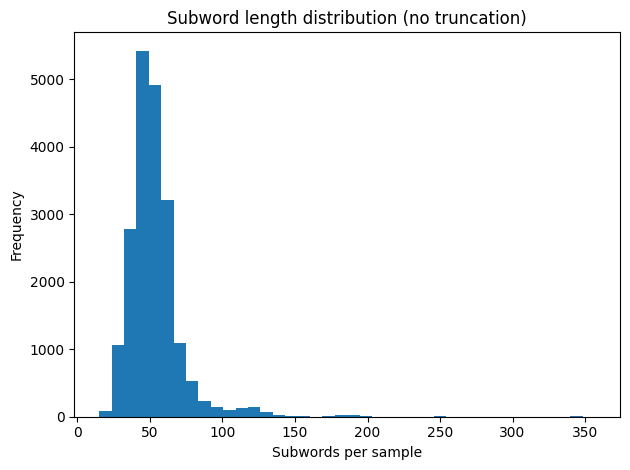

In [ ]:

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)


sample_texts = train_ds["text"][:20000]

enc_no_trunc = tok(sample_texts, truncation=False, add_special_tokens=True)
sub_lens = np.array([len(ids) for ids in enc_no_trunc["input_ids"]])


p50 = float(np.percentile(sub_lens, 50))
p95 = float(np.percentile(sub_lens, 95))
trunc_at_128 = float((sub_lens > 128).mean())
trunc_at_256 = float((sub_lens > 256).mean())

print({"p50": p50, "p95": p95, "trunc@128": trunc_at_128, "trunc@256": trunc_at_256})

plt.figure()
plt.hist(sub_lens, bins=40)
plt.title("Subword length distribution (no truncation)")
plt.xlabel("Subwords per sample"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("results/eda_len_subword.png", dpi=300)
plt.show()

In [ ]:
def preprocess(examples):
    return tok(examples["text"], truncation=True, padding=False, max_length=128)

enc_train = train_ds.map(preprocess, batched=True).rename_column("label","labels").with_format("torch")
enc_val   = val_ds  .map(preprocess, batched=True).rename_column("label","labels").with_format("torch")

collator = DataCollatorWithPadding(tok)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

{'accuracy': 0.9222, 'macro_f1': 0.922}

               precision    recall  f1-score   support

       World       0.93      0.91      0.92      3000
      Sports       0.96      0.98      0.97      3000
    Business       0.90      0.88      0.89      3000
    Sci/Tech       0.89      0.91      0.90      3000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



<Figure size 520x440 with 0 Axes>

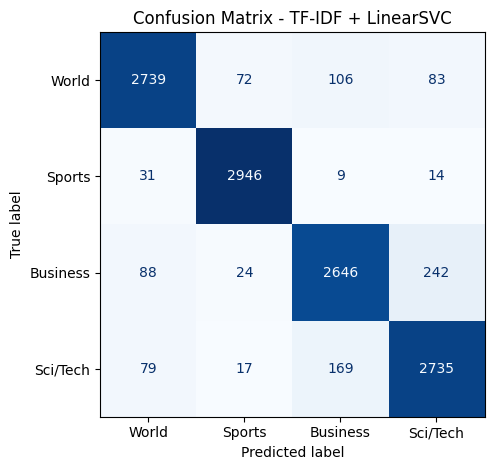

In [ ]:
X_tr, y_tr = train_ds["text"], train_ds["label"]
X_va, y_va = val_ds["text"],   val_ds["label"]

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=100_000, lowercase=True)
Xtr = tfidf.fit_transform(X_tr)
Xva = tfidf.transform(X_va)

clf = LinearSVC(random_state=42)
clf.fit(Xtr, y_tr)

pred = clf.predict(Xva)
acc  = accuracy_score(y_va, pred)
mf1  = f1_score(y_va, pred, average="macro")
print({"accuracy": round(acc,4), "macro_f1": round(mf1,4)})
print("\n", classification_report(y_va, pred, target_names=["World","Sports","Business","Sci/Tech"]))


labels4 = ["World","Sports","Business","Sci/Tech"]
cm = confusion_matrix(y_va, pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(cm, display_labels=labels4)
plt.figure(figsize=(5.2,4.4))
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix - TF-IDF + LinearSVC")
plt.tight_layout()
plt.savefig("results/confmat_tfidf_svm.png", dpi=300)
plt.show()